<a href="https://colab.research.google.com/github/tenten0727/benchmarkUpdate1/blob/master/benchmarkUpdate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# googleマウント

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# ライブラリのインポート

In [2]:
!pip install optuna
import pandas as pd
import optuna.integration.lightgbm as lgb
import numpy as np
import warnings
import gc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from google.colab import files
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import datetime
import collections

warnings.simplefilter('ignore')


     |████████████████████████████████| 235kB 3.2MB/s 
     |████████████████████████████████| 1.1MB 6.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 81kB 4.3MB/s 
     |████████████████████████████████| 112kB 15.8MB/s 
     |████████████████████████████████| 133kB 14.2MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159540 sha256=3f7408ab07a5b11d83d8502ad0161098567f0607976c6ba975afc8aabb0e7b46
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-2.0.0-cp36-none-any.whl size=312967 sha256=d7763f681c7640b89224965d5853148418abc78749645a3b434e46546bf370a2
  Stored in directory: /root/.cache/pip/wheels/b5/

# data読み込み

In [3]:
train_df = pd.read_csv('/content/gdrive/My Drive/SIGNATE/Beginner1/train.csv')
test_df = pd.read_csv('/content/gdrive/My Drive/SIGNATE/Beginner1/test.csv')
submit_df = pd.read_csv('/content/gdrive/My Drive/SIGNATE/Beginner1/submit_sample.csv',header=None)

categorical_features = ['job', 'marital', 'education','default','housing','loan','contact','month','poutcome']

In [4]:
print(train_df['job'].unique())
train_df.describe(include='all')

['services' 'entrepreneur' 'management' 'technician' 'unemployed'
 'blue-collar' 'admin.' 'retired' 'self-employed' 'housemaid' 'student']


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,27100.000000,27100.000000,27100,27100,27100,27100,27100.000000,27100,27100,27100,27100.000000,27100,27100.000000,27100.000000,27100.000000,27100.000000,27100,27100.000000
unique,NaN,NaN,11,3,4,2,NaN,2,2,3,NaN,11,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,NaN
freq,NaN,NaN,5957,17565,15955,27090,NaN,15819,23651,19147,NaN,11232,NaN,NaN,NaN,NaN,23099,NaN
mean,13549.500000,36.073284,NaN,NaN,NaN,NaN,47682.901771,NaN,NaN,NaN,16.747565,NaN,229.325387,1.775830,432.482399,0.085720,NaN,0.077934
std,7823.240484,7.816417,NaN,NaN,NaN,NaN,31650.760036,NaN,NaN,NaN,8.569588,NaN,204.939958,0.950045,252.150648,0.365889,NaN,0.268072
min,0.000000,22.000000,NaN,NaN,NaN,NaN,-6847.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,0.000000
25%,6774.750000,31.000000,NaN,NaN,NaN,NaN,20015.750000,NaN,NaN,NaN,8.000000,NaN,121.000000,1.000000,214.000000,0.000000,NaN,0.000000
50%,13549.500000,33.000000,NaN,NaN,NaN,NaN,47624.000000,NaN,NaN,NaN,17.000000,NaN,158.000000,1.000000,432.000000,0.000000,NaN,0.000000
75%,20324.250000,37.000000,NaN,NaN,NaN,NaN,75330.000000,NaN,NaN,NaN,26.000000,NaN,345.000000,2.000000,650.000000,0.000000,NaN,0.000000


In [5]:
print(test_df['job'].unique())
test_df.describe(include='all')

['technician' 'services' 'admin.' 'management' 'blue-collar'
 'self-employed' 'housemaid' 'unemployed' 'retired' 'entrepreneur'
 'student' 'unknown']


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
count,18050.000000,18050.000000,18050,18050,18050,18050,18050.000000,18050,18050,18050,18050.000000,18050,18050.000000,18050.000000,18050.000000,18050.000000,18050
unique,NaN,NaN,12,3,4,2,NaN,2,2,3,NaN,11,NaN,NaN,NaN,NaN,4
top,NaN,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown
freq,NaN,NaN,4086,11653,10799,18046,NaN,10418,15729,12607,NaN,7586,NaN,NaN,NaN,NaN,15426
mean,9024.500000,36.104266,NaN,NaN,NaN,NaN,47158.451801,NaN,NaN,NaN,16.763934,NaN,229.315014,1.770083,436.171801,0.090859,NaN
std,5210.730515,7.863805,NaN,NaN,NaN,NaN,31469.525699,NaN,NaN,NaN,8.571112,NaN,208.796946,0.944872,251.392519,0.375801,NaN
min,0.000000,20.000000,NaN,NaN,NaN,NaN,-6838.000000,NaN,NaN,NaN,2.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN
25%,4512.250000,31.000000,NaN,NaN,NaN,NaN,19654.500000,NaN,NaN,NaN,8.000000,NaN,121.000000,1.000000,219.250000,0.000000,NaN
50%,9024.500000,33.000000,NaN,NaN,NaN,NaN,46886.000000,NaN,NaN,NaN,17.000000,NaN,158.000000,1.000000,436.000000,0.000000,NaN
75%,13536.750000,37.000000,NaN,NaN,NaN,NaN,74178.000000,NaN,NaN,NaN,26.000000,NaN,345.000000,2.000000,654.000000,0.000000,NaN


In [6]:
for column in test_df[categorical_features].columns:
  dif_column = set(train_df[column].unique()) ^ set(test_df[column].unique())
  print('%s: different %s' %(column,  dif_column))


job: different {'unknown'}
marital: different set()
education: different set()
default: different set()
housing: different set()
loan: different set()
contact: different set()
month: different set()
poutcome: different set()


# data量確認

In [7]:
train_df.shape, test_df.shape, submit_df.shape

((27100, 18), (18050, 17), (18050, 2))

# testデータがわかるようにダミーの目的変数を代入

In [8]:
test_df['y']=-999

# trainデータ、testデータを結合

In [9]:
all_df = pd.concat([train_df, test_df])
del train_df, test_df
gc.collect()
all_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


# カテゴリカラムの前処理

In [10]:
for col in categorical_features:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(all_df[col])
    all_df[col]=lbl.transform(all_df[col])


## ターゲットエンコーディング

In [11]:
for category in categorical_features:
  target_mean = all_df[all_df['y'] != -999].groupby(category).y.mean()
  if(category == 'job'):
    target_mean.loc[11] = np.mean(target_mean.values)
  all_df['target_'+category] = all_df[category].map(target_mean)
  print(target_mean)
  all_df.drop(column, axis=1)

all_df.head()

job
0     0.086602
1     0.057915
2     0.082251
3     0.090186
4     0.086607
5     0.167331
6     0.096303
7     0.065965
8     0.294618
9     0.042930
10    0.134591
11    0.109573
Name: y, dtype: float64
marital
0    0.064476
1    0.062511
2    0.120704
Name: y, dtype: float64
education
0    0.065185
1    0.064369
2    0.104498
3    0.151993
Name: y, dtype: float64
default
0    0.077962
1    0.000000
Name: y, dtype: float64
housing
0    0.130219
1    0.040647
Name: y, dtype: float64
loan
0    0.084352
1    0.033923
Name: y, dtype: float64
contact
0    0.091346
1    0.089674
2    0.038546
Name: y, dtype: float64
month
0     0.203491
1     0.068323
2     0.148661
3     0.127424
4     0.086786
5     0.057032
6     0.462617
7     0.044160
8     0.062852
9     0.567010
10    0.296296
Name: y, dtype: float64
poutcome
0    0.043798
1    0.048426
2    0.679039
3    0.071085
Name: y, dtype: float64


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,target_job,target_marital,target_education,target_default,target_housing,target_loan,target_contact,target_month,target_poutcome
0,0,31,7,1,1,0,12294,1,0,0,21,8,101,3,498,0,1,0,0.065965,0.062511,0.064369,0.077962,0.040647,0.084352,0.091346,0.062852,0.048426
1,1,29,2,2,2,0,43027,0,0,0,22,1,158,2,702,0,3,1,0.082251,0.120704,0.104498,0.077962,0.130219,0.084352,0.091346,0.068323,0.071085
2,2,35,4,1,2,0,12252,1,0,0,11,8,351,1,826,0,0,0,0.086607,0.062511,0.104498,0.077962,0.040647,0.084352,0.091346,0.062852,0.043798
3,3,31,9,1,1,0,99121,1,1,2,16,7,658,2,120,0,0,0,0.042930,0.062511,0.064369,0.077962,0.040647,0.033923,0.038546,0.044160,0.043798
4,4,48,10,1,0,0,42005,1,0,1,3,0,177,1,273,0,3,0,0.134591,0.062511,0.065185,0.077962,0.040647,0.084352,0.089674,0.203491,0.071085


## Count Encoding

In [12]:
# for category in categorical_features:
#   counters = collections.Counter(all_df[all_df['y'] != -999][category].values)
#   all_df['count_'+category] = all_df[category].map(counters)
#   all_df[category].drop

# all_df.head()

特徴量選択

# train, testに再度分割

In [13]:
train_df = all_df[all_df['y'] != -999]
test_df = all_df[all_df['y'] == -999]

y_train = train_df['y']
X_train = train_df.drop(['y', 'id'], axis=1)
X_test = test_df.drop(['y', 'id'], axis=1)

# trainをさらに分割

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=00.3, random_state=0, stratify=y_train)

# ligitgbmを使用

In [15]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

params = {
    'objective': 'binary'
}

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=1000,
    early_stopping_rounds=100
)



feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.214054	valid_1's binary_logloss: 0.220973
[20]	training's binary_logloss: 0.195542	valid_1's binary_logloss: 0.208762
[30]	training's binary_logloss: 0.183706	valid_1's binary_logloss: 0.203648
[40]	training's binary_logloss: 0.174593	valid_1's binary_logloss: 0.201398
[50]	training's binary_logloss: 0.167628	valid_1's binary_logloss: 0.200411
[60]	training's binary_logloss: 0.161442	valid_1's binary_logloss: 0.200033
[70]	training's binary_logloss: 0.155996	valid_1's binary_logloss: 0.200189
[80]	training's binary_logloss: 0.150372	valid_1's binary_logloss: 0.20047
[90]	training's binary_logloss: 0.145734	valid_1's binary_logloss: 0.200707
[100]	training's binary_logloss: 0.140852	valid_1's binary_logloss: 0.201224
[110]	training's binary_logloss: 0.136793	valid_1's binary_logloss: 0.2013
[120]	training's binary_logloss: 0.133069	valid_1's binary_logloss: 0.201861
[130]	training's binary_l

feature_fraction, val_score: 0.199886:  14%|#4        | 1/7 [00:00<00:05,  1.15it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.209841	valid_1's binary_logloss: 0.218468
[20]	training's binary_logloss: 0.191349	valid_1's binary_logloss: 0.207473
[30]	training's binary_logloss: 0.17956	valid_1's binary_logloss: 0.202755
[40]	training's binary_logloss: 0.170851	valid_1's binary_logloss: 0.201275
[50]	training's binary_logloss: 0.16389	valid_1's binary_logloss: 0.20022
[60]	training's binary_logloss: 0.15751	valid_1's binary_logloss: 0.200505
[70]	training's binary_logloss: 0.151727	valid_1's binary_logloss: 0.200493
[80]	training's binary_logloss: 0.146521	valid_1's binary_logloss: 0.200372
[90]	training's binary_logloss: 0.141188	valid_1's binary_logloss: 0.200884
[100]	training's binary_logloss: 0.136576	valid_1's binary_logloss: 0.201305
[110]	training's binary_logloss: 0.132505	valid_1's binary_logloss: 0.201641
[120]	training's binary_logloss: 0.12795	valid_1's binary_logloss: 0.202052
[130]	training's binary_log

feature_fraction, val_score: 0.199886:  29%|##8       | 2/7 [00:01<00:04,  1.17it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.209491	valid_1's binary_logloss: 0.21749
[20]	training's binary_logloss: 0.190543	valid_1's binary_logloss: 0.207661
[30]	training's binary_logloss: 0.17807	valid_1's binary_logloss: 0.202854
[40]	training's binary_logloss: 0.168671	valid_1's binary_logloss: 0.200912
[50]	training's binary_logloss: 0.161086	valid_1's binary_logloss: 0.200194
[60]	training's binary_logloss: 0.155031	valid_1's binary_logloss: 0.199958
[70]	training's binary_logloss: 0.148499	valid_1's binary_logloss: 0.200314
[80]	training's binary_logloss: 0.142576	valid_1's binary_logloss: 0.200578
[90]	training's binary_logloss: 0.137242	valid_1's binary_logloss: 0.201041
[100]	training's binary_logloss: 0.132731	valid_1's binary_logloss: 0.202096
[110]	training's binary_logloss: 0.128017	valid_1's binary_logloss: 0.202628
[120]	training's binary_logloss: 0.12372	valid_1's binary_logloss: 0.203405
[130]	training's binary_l

feature_fraction, val_score: 0.199886:  43%|####2     | 3/7 [00:02<00:03,  1.18it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.209074	valid_1's binary_logloss: 0.218342
[20]	training's binary_logloss: 0.190616	valid_1's binary_logloss: 0.208175
[30]	training's binary_logloss: 0.178052	valid_1's binary_logloss: 0.204207
[40]	training's binary_logloss: 0.167757	valid_1's binary_logloss: 0.202241
[50]	training's binary_logloss: 0.159883	valid_1's binary_logloss: 0.202294
[60]	training's binary_logloss: 0.152339	valid_1's binary_logloss: 0.202388
[70]	training's binary_logloss: 0.145566	valid_1's binary_logloss: 0.203051
[80]	training's binary_logloss: 0.139767	valid_1's binary_logloss: 0.203394
[90]	training's binary_logloss: 0.13431	valid_1's binary_logloss: 0.203905
[100]	training's binary_logloss: 0.129172	valid_1's binary_logloss: 0.204612
[110]	training's binary_logloss: 0.124329	valid_1's binary_logloss: 0.20513
[120]	training's binary_logloss: 0.119585	valid_1's binary_logloss: 0.205312
[130]	training's binary_

feature_fraction, val_score: 0.199886:  57%|#####7    | 4/7 [00:03<00:02,  1.18it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.210896	valid_1's binary_logloss: 0.219362
[20]	training's binary_logloss: 0.192588	valid_1's binary_logloss: 0.207547
[30]	training's binary_logloss: 0.181539	valid_1's binary_logloss: 0.203026
[40]	training's binary_logloss: 0.172766	valid_1's binary_logloss: 0.201077
[50]	training's binary_logloss: 0.165286	valid_1's binary_logloss: 0.200031
[60]	training's binary_logloss: 0.159344	valid_1's binary_logloss: 0.19986
[70]	training's binary_logloss: 0.153258	valid_1's binary_logloss: 0.199941
[80]	training's binary_logloss: 0.148401	valid_1's binary_logloss: 0.200708
[90]	training's binary_logloss: 0.14375	valid_1's binary_logloss: 0.200993
[100]	training's binary_logloss: 0.139393	valid_1's binary_logloss: 0.20092
[110]	training's binary_logloss: 0.135765	valid_1's binary_logloss: 0.201521
[120]	training's binary_logloss: 0.131291	valid_1's binary_logloss: 0.201637
[130]	training's binary_l

feature_fraction, val_score: 0.199679:  71%|#######1  | 5/7 [00:04<00:01,  1.21it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.208796	valid_1's binary_logloss: 0.21839
[20]	training's binary_logloss: 0.19051	valid_1's binary_logloss: 0.208611
[30]	training's binary_logloss: 0.177152	valid_1's binary_logloss: 0.204434
[40]	training's binary_logloss: 0.167489	valid_1's binary_logloss: 0.202809
[50]	training's binary_logloss: 0.15937	valid_1's binary_logloss: 0.203028
[60]	training's binary_logloss: 0.151745	valid_1's binary_logloss: 0.203274
[70]	training's binary_logloss: 0.145076	valid_1's binary_logloss: 0.203639
[80]	training's binary_logloss: 0.139296	valid_1's binary_logloss: 0.204377
[90]	training's binary_logloss: 0.133775	valid_1's binary_logloss: 0.204822
[100]	training's binary_logloss: 0.12913	valid_1's binary_logloss: 0.205467
[110]	training's binary_logloss: 0.124078	valid_1's binary_logloss: 0.205928
[120]	training's binary_logloss: 0.119685	valid_1's binary_logloss: 0.20644
[130]	training's binary_log

feature_fraction, val_score: 0.199679:  86%|########5 | 6/7 [00:04<00:00,  1.21it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.20938	valid_1's binary_logloss: 0.218108
[20]	training's binary_logloss: 0.191187	valid_1's binary_logloss: 0.207241
[30]	training's binary_logloss: 0.178924	valid_1's binary_logloss: 0.203009
[40]	training's binary_logloss: 0.169264	valid_1's binary_logloss: 0.201535
[50]	training's binary_logloss: 0.161453	valid_1's binary_logloss: 0.201461
[60]	training's binary_logloss: 0.154869	valid_1's binary_logloss: 0.201393
[70]	training's binary_logloss: 0.148924	valid_1's binary_logloss: 0.201709
[80]	training's binary_logloss: 0.143547	valid_1's binary_logloss: 0.201812
[90]	training's binary_logloss: 0.138056	valid_1's binary_logloss: 0.202265
[100]	training's binary_logloss: 0.133325	valid_1's binary_logloss: 0.20284
[110]	training's binary_logloss: 0.12854	valid_1's binary_logloss: 0.203399
[120]	training's binary_logloss: 0.124499	valid_1's binary_logloss: 0.203928
[130]	training's binary_l

num_leaves, val_score: 0.199679:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.212028	valid_1's binary_logloss: 0.219469
[20]	training's binary_logloss: 0.193959	valid_1's binary_logloss: 0.207771
[30]	training's binary_logloss: 0.183283	valid_1's binary_logloss: 0.20329
[40]	training's binary_logloss: 0.174583	valid_1's binary_logloss: 0.20127
[50]	training's binary_logloss: 0.167149	valid_1's binary_logloss: 0.200439
[60]	training's binary_logloss: 0.161268	valid_1's binary_logloss: 0.200273
[70]	training's binary_logloss: 0.155191	valid_1's binary_logloss: 0.200096
[80]	training's binary_logloss: 0.150213	valid_1's binary_logloss: 0.200668
[90]	training's binary_logloss: 0.145382	valid_1's binary_logloss: 0.201103
[100]	training's binary_logloss: 0.141371	valid_1's binary_logloss: 0.201544
[110]	training's binary_logloss: 0.137802	valid_1's binary_logloss: 0.201821
[120]	training's binary_logloss: 0.133944	valid_1's binary_logloss: 0.202512
[130]	training's binary_

num_leaves, val_score: 0.199679:   5%|5         | 1/20 [00:00<00:14,  1.27it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.182041	valid_1's binary_logloss: 0.216634
[20]	training's binary_logloss: 0.145854	valid_1's binary_logloss: 0.208138
[30]	training's binary_logloss: 0.12224	valid_1's binary_logloss: 0.205854
[40]	training's binary_logloss: 0.10236	valid_1's binary_logloss: 0.2071
[50]	training's binary_logloss: 0.0878609	valid_1's binary_logloss: 0.20819
[60]	training's binary_logloss: 0.0769008	valid_1's binary_logloss: 0.210224
[70]	training's binary_logloss: 0.0671325	valid_1's binary_logloss: 0.212618
[80]	training's binary_logloss: 0.0589551	valid_1's binary_logloss: 0.216053
[90]	training's binary_logloss: 0.0520369	valid_1's binary_logloss: 0.219327
[100]	training's binary_logloss: 0.0461242	valid_1's binary_logloss: 0.222259
[110]	training's binary_logloss: 0.0412452	valid_1's binary_logloss: 0.22534
[120]	training's binary_logloss: 0.0364979	valid_1's binary_logloss: 0.228661
Early stopping, best

num_leaves, val_score: 0.199679:  10%|#         | 2/20 [00:01<00:15,  1.14it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.202104	valid_1's binary_logloss: 0.21755
[20]	training's binary_logloss: 0.178738	valid_1's binary_logloss: 0.207467
[30]	training's binary_logloss: 0.163677	valid_1's binary_logloss: 0.203305
[40]	training's binary_logloss: 0.150989	valid_1's binary_logloss: 0.201586
[50]	training's binary_logloss: 0.141033	valid_1's binary_logloss: 0.201569
[60]	training's binary_logloss: 0.132487	valid_1's binary_logloss: 0.201772
[70]	training's binary_logloss: 0.125879	valid_1's binary_logloss: 0.202439
[80]	training's binary_logloss: 0.117911	valid_1's binary_logloss: 0.203642
[90]	training's binary_logloss: 0.111853	valid_1's binary_logloss: 0.204139
[100]	training's binary_logloss: 0.10656	valid_1's binary_logloss: 0.205276
[110]	training's binary_logloss: 0.101685	valid_1's binary_logloss: 0.206182
[120]	training's binary_logloss: 0.0963169	valid_1's binary_logloss: 0.207129
[130]	training's binary

num_leaves, val_score: 0.199679:  15%|#5        | 3/20 [00:02<00:15,  1.13it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.169001	valid_1's binary_logloss: 0.217188
[20]	training's binary_logloss: 0.124873	valid_1's binary_logloss: 0.209551
[30]	training's binary_logloss: 0.0971164	valid_1's binary_logloss: 0.208026
[40]	training's binary_logloss: 0.0741512	valid_1's binary_logloss: 0.211523
[50]	training's binary_logloss: 0.0585471	valid_1's binary_logloss: 0.215583
[60]	training's binary_logloss: 0.047063	valid_1's binary_logloss: 0.22049
[70]	training's binary_logloss: 0.0376761	valid_1's binary_logloss: 0.226898
[80]	training's binary_logloss: 0.0302639	valid_1's binary_logloss: 0.232853
[90]	training's binary_logloss: 0.0245087	valid_1's binary_logloss: 0.239663
[100]	training's binary_logloss: 0.0202301	valid_1's binary_logloss: 0.246508
[110]	training's binary_logloss: 0.0169648	valid_1's binary_logloss: 0.253349
[120]	training's binary_logloss: 0.0136268	valid_1's binary_logloss: 0.261111
Early stopping

num_leaves, val_score: 0.199679:  20%|##        | 4/20 [00:04<00:16,  1.06s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.168457	valid_1's binary_logloss: 0.217011
[20]	training's binary_logloss: 0.12432	valid_1's binary_logloss: 0.209167
[30]	training's binary_logloss: 0.0962026	valid_1's binary_logloss: 0.207567
[40]	training's binary_logloss: 0.0735292	valid_1's binary_logloss: 0.211115
[50]	training's binary_logloss: 0.0580285	valid_1's binary_logloss: 0.215346
[60]	training's binary_logloss: 0.0465538	valid_1's binary_logloss: 0.219623
[70]	training's binary_logloss: 0.0371608	valid_1's binary_logloss: 0.225938
[80]	training's binary_logloss: 0.0296346	valid_1's binary_logloss: 0.233936
[90]	training's binary_logloss: 0.024337	valid_1's binary_logloss: 0.240713
[100]	training's binary_logloss: 0.0198511	valid_1's binary_logloss: 0.24777
[110]	training's binary_logloss: 0.01639	valid_1's binary_logloss: 0.254487
[120]	training's binary_logloss: 0.0130856	valid_1's binary_logloss: 0.263055
Early stopping, b

num_leaves, val_score: 0.199679:  25%|##5       | 5/20 [00:05<00:17,  1.19s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.180888	valid_1's binary_logloss: 0.217146
[20]	training's binary_logloss: 0.14379	valid_1's binary_logloss: 0.208042
[30]	training's binary_logloss: 0.120074	valid_1's binary_logloss: 0.206022
[40]	training's binary_logloss: 0.100366	valid_1's binary_logloss: 0.207747
[50]	training's binary_logloss: 0.0855828	valid_1's binary_logloss: 0.209095
[60]	training's binary_logloss: 0.0740373	valid_1's binary_logloss: 0.211298
[70]	training's binary_logloss: 0.0639782	valid_1's binary_logloss: 0.214027
[80]	training's binary_logloss: 0.0550418	valid_1's binary_logloss: 0.217317
[90]	training's binary_logloss: 0.0481649	valid_1's binary_logloss: 0.220955
[100]	training's binary_logloss: 0.0425218	valid_1's binary_logloss: 0.224878
[110]	training's binary_logloss: 0.0378155	valid_1's binary_logloss: 0.227957
[120]	training's binary_logloss: 0.0330431	valid_1's binary_logloss: 0.232761
Early stopping,

num_leaves, val_score: 0.199679:  30%|###       | 6/20 [00:06<00:16,  1.17s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.195295	valid_1's binary_logloss: 0.217843
[20]	training's binary_logloss: 0.168049	valid_1's binary_logloss: 0.207415
[30]	training's binary_logloss: 0.149873	valid_1's binary_logloss: 0.203776
[40]	training's binary_logloss: 0.134803	valid_1's binary_logloss: 0.203328
[50]	training's binary_logloss: 0.123121	valid_1's binary_logloss: 0.203006
[60]	training's binary_logloss: 0.113349	valid_1's binary_logloss: 0.203142
[70]	training's binary_logloss: 0.104537	valid_1's binary_logloss: 0.203742
[80]	training's binary_logloss: 0.0964693	valid_1's binary_logloss: 0.204798
[90]	training's binary_logloss: 0.089653	valid_1's binary_logloss: 0.206085
[100]	training's binary_logloss: 0.0840143	valid_1's binary_logloss: 0.207313
[110]	training's binary_logloss: 0.0789406	valid_1's binary_logloss: 0.208833
[120]	training's binary_logloss: 0.073481	valid_1's binary_logloss: 0.210322
[130]	training's bi

num_leaves, val_score: 0.199679:  35%|###5      | 7/20 [00:07<00:14,  1.11s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.173881	valid_1's binary_logloss: 0.21722
[20]	training's binary_logloss: 0.13311	valid_1's binary_logloss: 0.209528
[30]	training's binary_logloss: 0.106055	valid_1's binary_logloss: 0.207604
[40]	training's binary_logloss: 0.0840723	valid_1's binary_logloss: 0.210013
[50]	training's binary_logloss: 0.0687407	valid_1's binary_logloss: 0.212088
[60]	training's binary_logloss: 0.0573152	valid_1's binary_logloss: 0.215462
[70]	training's binary_logloss: 0.0472455	valid_1's binary_logloss: 0.2199
[80]	training's binary_logloss: 0.0390966	valid_1's binary_logloss: 0.22549
[90]	training's binary_logloss: 0.03269	valid_1's binary_logloss: 0.231479
[100]	training's binary_logloss: 0.0278358	valid_1's binary_logloss: 0.236744
[110]	training's binary_logloss: 0.0240028	valid_1's binary_logloss: 0.243184
[120]	training's binary_logloss: 0.0199671	valid_1's binary_logloss: 0.249758
Early stopping, best

num_leaves, val_score: 0.199679:  40%|####      | 8/20 [00:09<00:13,  1.16s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.238186	valid_1's binary_logloss: 0.238418
[20]	training's binary_logloss: 0.228601	valid_1's binary_logloss: 0.228767
[30]	training's binary_logloss: 0.223008	valid_1's binary_logloss: 0.22298
[40]	training's binary_logloss: 0.219329	valid_1's binary_logloss: 0.218817
[50]	training's binary_logloss: 0.216118	valid_1's binary_logloss: 0.215655
[60]	training's binary_logloss: 0.213661	valid_1's binary_logloss: 0.213283
[70]	training's binary_logloss: 0.211932	valid_1's binary_logloss: 0.211478
[80]	training's binary_logloss: 0.210351	valid_1's binary_logloss: 0.210086
[90]	training's binary_logloss: 0.208946	valid_1's binary_logloss: 0.208816
[100]	training's binary_logloss: 0.207716	valid_1's binary_logloss: 0.207705
[110]	training's binary_logloss: 0.206607	valid_1's binary_logloss: 0.206775
[120]	training's binary_logloss: 0.205671	valid_1's binary_logloss: 0.206162
[130]	training's binary

num_leaves, val_score: 0.198392:  45%|####5     | 9/20 [00:12<00:19,  1.73s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

num_leaves, val_score: 0.197935:  50%|#####     | 10/20 [00:13<00:17,  1.73s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.246756	valid_1's binary_logloss: 0.24609
[20]	training's binary_logloss: 0.237939	valid_1's binary_logloss: 0.237789
[30]	training's binary_logloss: 0.232906	valid_1's binary_logloss: 0.23284
[40]	training's binary_logloss: 0.229666	valid_1's binary_logloss: 0.229347
[50]	training's binary_logloss: 0.227085	valid_1's binary_logloss: 0.226586
[60]	training's binary_logloss: 0.225082	valid_1's binary_logloss: 0.224375
[70]	training's binary_logloss: 0.223405	valid_1's binary_logloss: 0.222642
[80]	training's binary_logloss: 0.221933	valid_1's binary_logloss: 0.221146
[90]	training's binary_logloss: 0.220618	valid_1's binary_logloss: 0.219793
[100]	training's binary_logloss: 0.219445	valid_1's binary_logloss: 0.218443
[110]	training's binary_logloss: 0.218408	valid_1's binary_logloss: 0.217326
[120]	training's binary_logloss: 0.217477	valid_1's binary_logloss: 0.216371
[130]	training's binary_

num_leaves, val_score: 0.197935:  55%|#####5    | 11/20 [00:17<00:19,  2.17s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.238186	valid_1's binary_logloss: 0.238418
[20]	training's binary_logloss: 0.228601	valid_1's binary_logloss: 0.228767
[30]	training's binary_logloss: 0.223008	valid_1's binary_logloss: 0.22298
[40]	training's binary_logloss: 0.219329	valid_1's binary_logloss: 0.218817
[50]	training's binary_logloss: 0.216118	valid_1's binary_logloss: 0.215655
[60]	training's binary_logloss: 0.213661	valid_1's binary_logloss: 0.213283
[70]	training's binary_logloss: 0.211932	valid_1's binary_logloss: 0.211478
[80]	training's binary_logloss: 0.210351	valid_1's binary_logloss: 0.210086
[90]	training's binary_logloss: 0.208946	valid_1's binary_logloss: 0.208816
[100]	training's binary_logloss: 0.207716	valid_1's binary_logloss: 0.207705
[110]	training's binary_logloss: 0.206607	valid_1's binary_logloss: 0.206775
[120]	training's binary_logloss: 0.205671	valid_1's binary_logloss: 0.206162
[130]	training's binary

num_leaves, val_score: 0.197935:  60%|######    | 12/20 [00:20<00:19,  2.47s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.192808	valid_1's binary_logloss: 0.217356
[20]	training's binary_logloss: 0.163851	valid_1's binary_logloss: 0.207483
[30]	training's binary_logloss: 0.14481	valid_1's binary_logloss: 0.204026
[40]	training's binary_logloss: 0.128138	valid_1's binary_logloss: 0.203803
[50]	training's binary_logloss: 0.115782	valid_1's binary_logloss: 0.203218
[60]	training's binary_logloss: 0.105994	valid_1's binary_logloss: 0.204275
[70]	training's binary_logloss: 0.0968005	valid_1's binary_logloss: 0.205683
[80]	training's binary_logloss: 0.0887833	valid_1's binary_logloss: 0.206865
[90]	training's binary_logloss: 0.081621	valid_1's binary_logloss: 0.208435
[100]	training's binary_logloss: 0.0757351	valid_1's binary_logloss: 0.21043
[110]	training's binary_logloss: 0.0707114	valid_1's binary_logloss: 0.211854
[120]	training's binary_logloss: 0.0651232	valid_1's binary_logloss: 0.2136
[130]	training's bina

num_leaves, val_score: 0.197935:  65%|######5   | 13/20 [00:21<00:14,  2.04s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.238186	valid_1's binary_logloss: 0.238418
[20]	training's binary_logloss: 0.228601	valid_1's binary_logloss: 0.228767
[30]	training's binary_logloss: 0.223008	valid_1's binary_logloss: 0.22298
[40]	training's binary_logloss: 0.219329	valid_1's binary_logloss: 0.218817
[50]	training's binary_logloss: 0.216118	valid_1's binary_logloss: 0.215655
[60]	training's binary_logloss: 0.213661	valid_1's binary_logloss: 0.213283
[70]	training's binary_logloss: 0.211932	valid_1's binary_logloss: 0.211478
[80]	training's binary_logloss: 0.210351	valid_1's binary_logloss: 0.210086
[90]	training's binary_logloss: 0.208946	valid_1's binary_logloss: 0.208816
[100]	training's binary_logloss: 0.207716	valid_1's binary_logloss: 0.207705
[110]	training's binary_logloss: 0.206607	valid_1's binary_logloss: 0.206775
[120]	training's binary_logloss: 0.205671	valid_1's binary_logloss: 0.206162
[130]	training's binary

num_leaves, val_score: 0.197935:  70%|#######   | 14/20 [00:24<00:14,  2.38s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.246756	valid_1's binary_logloss: 0.24609
[20]	training's binary_logloss: 0.237939	valid_1's binary_logloss: 0.237789
[30]	training's binary_logloss: 0.232906	valid_1's binary_logloss: 0.23284
[40]	training's binary_logloss: 0.229666	valid_1's binary_logloss: 0.229347
[50]	training's binary_logloss: 0.227085	valid_1's binary_logloss: 0.226586
[60]	training's binary_logloss: 0.225082	valid_1's binary_logloss: 0.224375
[70]	training's binary_logloss: 0.223405	valid_1's binary_logloss: 0.222642
[80]	training's binary_logloss: 0.221933	valid_1's binary_logloss: 0.221146
[90]	training's binary_logloss: 0.220618	valid_1's binary_logloss: 0.219793
[100]	training's binary_logloss: 0.219445	valid_1's binary_logloss: 0.218443
[110]	training's binary_logloss: 0.218408	valid_1's binary_logloss: 0.217326
[120]	training's binary_logloss: 0.217477	valid_1's binary_logloss: 0.216371
[130]	training's binary_

num_leaves, val_score: 0.197935:  75%|#######5  | 15/20 [00:27<00:13,  2.64s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.208845	valid_1's binary_logloss: 0.218622
[20]	training's binary_logloss: 0.189335	valid_1's binary_logloss: 0.207164
[30]	training's binary_logloss: 0.177138	valid_1's binary_logloss: 0.202478
[40]	training's binary_logloss: 0.167766	valid_1's binary_logloss: 0.200977
[50]	training's binary_logloss: 0.159615	valid_1's binary_logloss: 0.199907
[60]	training's binary_logloss: 0.152531	valid_1's binary_logloss: 0.200122
[70]	training's binary_logloss: 0.145435	valid_1's binary_logloss: 0.200191
[80]	training's binary_logloss: 0.139602	valid_1's binary_logloss: 0.200528
[90]	training's binary_logloss: 0.133837	valid_1's binary_logloss: 0.201089
[100]	training's binary_logloss: 0.129547	valid_1's binary_logloss: 0.201644
[110]	training's binary_logloss: 0.125601	valid_1's binary_logloss: 0.202013
[120]	training's binary_logloss: 0.121308	valid_1's binary_logloss: 0.202514
[130]	training's binar

num_leaves, val_score: 0.197935:  80%|########  | 16/20 [00:28<00:08,  2.09s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.233823	valid_1's binary_logloss: 0.234045
[20]	training's binary_logloss: 0.223665	valid_1's binary_logloss: 0.224054
[30]	training's binary_logloss: 0.21771	valid_1's binary_logloss: 0.217744
[40]	training's binary_logloss: 0.213805	valid_1's binary_logloss: 0.213509
[50]	training's binary_logloss: 0.210621	valid_1's binary_logloss: 0.210636
[60]	training's binary_logloss: 0.208116	valid_1's binary_logloss: 0.208399
[70]	training's binary_logloss: 0.206284	valid_1's binary_logloss: 0.206922
[80]	training's binary_logloss: 0.204615	valid_1's binary_logloss: 0.205719
[90]	training's binary_logloss: 0.202909	valid_1's binary_logloss: 0.204623
[100]	training's binary_logloss: 0.201717	valid_1's binary_logloss: 0.204015
[110]	training's binary_logloss: 0.200584	valid_1's binary_logloss: 0.203344
[120]	training's binary_logloss: 0.199664	valid_1's binary_logloss: 0.203154
[130]	training's binary

num_leaves, val_score: 0.197935:  85%|########5 | 17/20 [00:30<00:06,  2.08s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.208845	valid_1's binary_logloss: 0.218622
[20]	training's binary_logloss: 0.189335	valid_1's binary_logloss: 0.207164
[30]	training's binary_logloss: 0.177138	valid_1's binary_logloss: 0.202478
[40]	training's binary_logloss: 0.167766	valid_1's binary_logloss: 0.200977
[50]	training's binary_logloss: 0.159615	valid_1's binary_logloss: 0.199907
[60]	training's binary_logloss: 0.152531	valid_1's binary_logloss: 0.200122
[70]	training's binary_logloss: 0.145435	valid_1's binary_logloss: 0.200191
[80]	training's binary_logloss: 0.139602	valid_1's binary_logloss: 0.200528
[90]	training's binary_logloss: 0.133837	valid_1's binary_logloss: 0.201089
[100]	training's binary_logloss: 0.129547	valid_1's binary_logloss: 0.201644
[110]	training's binary_logloss: 0.125601	valid_1's binary_logloss: 0.202013
[120]	training's binary_logloss: 0.121308	valid_1's binary_logloss: 0.202514
[130]	training's binar

num_leaves, val_score: 0.197935:  90%|######### | 18/20 [00:31<00:03,  1.69s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.192808	valid_1's binary_logloss: 0.217356
[20]	training's binary_logloss: 0.163851	valid_1's binary_logloss: 0.207483
[30]	training's binary_logloss: 0.14481	valid_1's binary_logloss: 0.204026
[40]	training's binary_logloss: 0.128138	valid_1's binary_logloss: 0.203803
[50]	training's binary_logloss: 0.115782	valid_1's binary_logloss: 0.203218
[60]	training's binary_logloss: 0.105994	valid_1's binary_logloss: 0.204275
[70]	training's binary_logloss: 0.0968005	valid_1's binary_logloss: 0.205683
[80]	training's binary_logloss: 0.0887833	valid_1's binary_logloss: 0.206865
[90]	training's binary_logloss: 0.081621	valid_1's binary_logloss: 0.208435
[100]	training's binary_logloss: 0.0757351	valid_1's binary_logloss: 0.21043
[110]	training's binary_logloss: 0.0707114	valid_1's binary_logloss: 0.211854
[120]	training's binary_logloss: 0.0651232	valid_1's binary_logloss: 0.2136
[130]	training's bina

num_leaves, val_score: 0.197935:  95%|#########5| 19/20 [00:32<00:01,  1.47s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.200159	valid_1's binary_logloss: 0.217543
[20]	training's binary_logloss: 0.175718	valid_1's binary_logloss: 0.207043
[30]	training's binary_logloss: 0.159734	valid_1's binary_logloss: 0.203368
[40]	training's binary_logloss: 0.146535	valid_1's binary_logloss: 0.202276
[50]	training's binary_logloss: 0.136132	valid_1's binary_logloss: 0.201893
[60]	training's binary_logloss: 0.12728	valid_1's binary_logloss: 0.202748
[70]	training's binary_logloss: 0.118852	valid_1's binary_logloss: 0.203484
[80]	training's binary_logloss: 0.111883	valid_1's binary_logloss: 0.203991
[90]	training's binary_logloss: 0.106004	valid_1's binary_logloss: 0.205246
[100]	training's binary_logloss: 0.0999817	valid_1's binary_logloss: 0.20606
[110]	training's binary_logloss: 0.0952748	valid_1's binary_logloss: 0.207077
[120]	training's binary_logloss: 0.090301	valid_1's binary_logloss: 0.208044
[130]	training's binar

bagging, val_score: 0.197935:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230515	valid_1's binary_logloss: 0.230372
[20]	training's binary_logloss: 0.220315	valid_1's binary_logloss: 0.220904
[30]	training's binary_logloss: 0.213888	valid_1's binary_logloss: 0.215204
[40]	training's binary_logloss: 0.20936	valid_1's binary_logloss: 0.211033
[50]	training's binary_logloss: 0.206197	valid_1's binary_logloss: 0.20817
[60]	training's binary_logloss: 0.203545	valid_1's binary_logloss: 0.206102
[70]	training's binary_logloss: 0.201338	valid_1's binary_logloss: 0.204593
[80]	training's binary_logloss: 0.199655	valid_1's binary_logloss: 0.203723
[90]	training's binary_logloss: 0.197982	valid_1's binary_logloss: 0.203261
[100]	training's binary_logloss: 0.19651	valid_1's binary_logloss: 0.202117
[110]	training's binary_logloss: 0.195015	valid_1's binary_logloss: 0.201519
[120]	training's binary_logloss: 0.193627	valid_1's binary_logloss: 0.201222
[130]	training's binary_l

bagging, val_score: 0.197935:  10%|#         | 1/10 [00:01<00:10,  1.20s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230737	valid_1's binary_logloss: 0.230788
[20]	training's binary_logloss: 0.220317	valid_1's binary_logloss: 0.220607
[30]	training's binary_logloss: 0.213872	valid_1's binary_logloss: 0.214189
[40]	training's binary_logloss: 0.209871	valid_1's binary_logloss: 0.209894
[50]	training's binary_logloss: 0.206936	valid_1's binary_logloss: 0.207479
[60]	training's binary_logloss: 0.204285	valid_1's binary_logloss: 0.205207
[70]	training's binary_logloss: 0.202275	valid_1's binary_logloss: 0.203893
[80]	training's binary_logloss: 0.200412	valid_1's binary_logloss: 0.202932
[90]	training's binary_logloss: 0.198727	valid_1's binary_logloss: 0.202106
[100]	training's binary_logloss: 0.197444	valid_1's binary_logloss: 0.201783
[110]	training's binary_logloss: 0.196024	valid_1's binary_logloss: 0.20108
[120]	training's binary_logloss: 0.194664	valid_1's binary_logloss: 0.200624
[130]	training's binary

bagging, val_score: 0.197935:  20%|##        | 2/10 [00:02<00:10,  1.32s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.231972	valid_1's binary_logloss: 0.232131
[20]	training's binary_logloss: 0.219895	valid_1's binary_logloss: 0.220268
[30]	training's binary_logloss: 0.213467	valid_1's binary_logloss: 0.213987
[40]	training's binary_logloss: 0.209663	valid_1's binary_logloss: 0.210848
[50]	training's binary_logloss: 0.205875	valid_1's binary_logloss: 0.207537
[60]	training's binary_logloss: 0.203965	valid_1's binary_logloss: 0.205909
[70]	training's binary_logloss: 0.202063	valid_1's binary_logloss: 0.204977
[80]	training's binary_logloss: 0.200417	valid_1's binary_logloss: 0.204193
[90]	training's binary_logloss: 0.198845	valid_1's binary_logloss: 0.204123
[100]	training's binary_logloss: 0.197124	valid_1's binary_logloss: 0.203837
[110]	training's binary_logloss: 0.195868	valid_1's binary_logloss: 0.203522
[120]	training's binary_logloss: 0.194571	valid_1's binary_logloss: 0.203248
[130]	training's binar

bagging, val_score: 0.197935:  30%|###       | 3/10 [00:04<00:09,  1.34s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230749	valid_1's binary_logloss: 0.231074
[20]	training's binary_logloss: 0.219828	valid_1's binary_logloss: 0.220109
[30]	training's binary_logloss: 0.213851	valid_1's binary_logloss: 0.214087
[40]	training's binary_logloss: 0.209854	valid_1's binary_logloss: 0.209946
[50]	training's binary_logloss: 0.206388	valid_1's binary_logloss: 0.206964
[60]	training's binary_logloss: 0.203948	valid_1's binary_logloss: 0.204946
[70]	training's binary_logloss: 0.201735	valid_1's binary_logloss: 0.203666
[80]	training's binary_logloss: 0.199919	valid_1's binary_logloss: 0.202716
[90]	training's binary_logloss: 0.198377	valid_1's binary_logloss: 0.202053
[100]	training's binary_logloss: 0.197037	valid_1's binary_logloss: 0.201526
[110]	training's binary_logloss: 0.195682	valid_1's binary_logloss: 0.200899
[120]	training's binary_logloss: 0.194239	valid_1's binary_logloss: 0.20059
[130]	training's binary

bagging, val_score: 0.197935:  40%|####      | 4/10 [00:05<00:08,  1.40s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.231085	valid_1's binary_logloss: 0.230926
[20]	training's binary_logloss: 0.220153	valid_1's binary_logloss: 0.220422
[30]	training's binary_logloss: 0.214056	valid_1's binary_logloss: 0.21436
[40]	training's binary_logloss: 0.210008	valid_1's binary_logloss: 0.210055
[50]	training's binary_logloss: 0.206524	valid_1's binary_logloss: 0.20715
[60]	training's binary_logloss: 0.204173	valid_1's binary_logloss: 0.205547
[70]	training's binary_logloss: 0.202115	valid_1's binary_logloss: 0.204097
[80]	training's binary_logloss: 0.200388	valid_1's binary_logloss: 0.203144
[90]	training's binary_logloss: 0.198806	valid_1's binary_logloss: 0.202187
[100]	training's binary_logloss: 0.197449	valid_1's binary_logloss: 0.201616
[110]	training's binary_logloss: 0.195863	valid_1's binary_logloss: 0.201188
[120]	training's binary_logloss: 0.194524	valid_1's binary_logloss: 0.201251
[130]	training's binary_

bagging, val_score: 0.197935:  50%|#####     | 5/10 [00:07<00:07,  1.44s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.231989	valid_1's binary_logloss: 0.232253
[20]	training's binary_logloss: 0.220383	valid_1's binary_logloss: 0.22094
[30]	training's binary_logloss: 0.213723	valid_1's binary_logloss: 0.21444
[40]	training's binary_logloss: 0.209639	valid_1's binary_logloss: 0.21125
[50]	training's binary_logloss: 0.206114	valid_1's binary_logloss: 0.207658
[60]	training's binary_logloss: 0.204187	valid_1's binary_logloss: 0.20631
[70]	training's binary_logloss: 0.202206	valid_1's binary_logloss: 0.205287
[80]	training's binary_logloss: 0.200353	valid_1's binary_logloss: 0.204108
[90]	training's binary_logloss: 0.198549	valid_1's binary_logloss: 0.204093
[100]	training's binary_logloss: 0.196929	valid_1's binary_logloss: 0.203667
[110]	training's binary_logloss: 0.195674	valid_1's binary_logloss: 0.203344
[120]	training's binary_logloss: 0.194752	valid_1's binary_logloss: 0.203094
[130]	training's binary_lo

bagging, val_score: 0.197935:  60%|######    | 6/10 [00:08<00:05,  1.49s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.231116	valid_1's binary_logloss: 0.231379
[20]	training's binary_logloss: 0.220792	valid_1's binary_logloss: 0.221011
[30]	training's binary_logloss: 0.213982	valid_1's binary_logloss: 0.214094
[40]	training's binary_logloss: 0.209996	valid_1's binary_logloss: 0.210448
[50]	training's binary_logloss: 0.206697	valid_1's binary_logloss: 0.207633
[60]	training's binary_logloss: 0.204592	valid_1's binary_logloss: 0.206612
[70]	training's binary_logloss: 0.202703	valid_1's binary_logloss: 0.205113
[80]	training's binary_logloss: 0.200741	valid_1's binary_logloss: 0.204142
[90]	training's binary_logloss: 0.199101	valid_1's binary_logloss: 0.203495
[100]	training's binary_logloss: 0.19776	valid_1's binary_logloss: 0.20295
[110]	training's binary_logloss: 0.196174	valid_1's binary_logloss: 0.202215
[120]	training's binary_logloss: 0.19468	valid_1's binary_logloss: 0.201573
[130]	training's binary_l

bagging, val_score: 0.197935:  70%|#######   | 7/10 [00:10<00:04,  1.41s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230699	valid_1's binary_logloss: 0.230593
[20]	training's binary_logloss: 0.219935	valid_1's binary_logloss: 0.219935
[30]	training's binary_logloss: 0.213257	valid_1's binary_logloss: 0.213788
[40]	training's binary_logloss: 0.209365	valid_1's binary_logloss: 0.209993
[50]	training's binary_logloss: 0.206213	valid_1's binary_logloss: 0.207264
[60]	training's binary_logloss: 0.203912	valid_1's binary_logloss: 0.205672
[70]	training's binary_logloss: 0.201798	valid_1's binary_logloss: 0.20448
[80]	training's binary_logloss: 0.199869	valid_1's binary_logloss: 0.203461
[90]	training's binary_logloss: 0.198054	valid_1's binary_logloss: 0.202376
[100]	training's binary_logloss: 0.196806	valid_1's binary_logloss: 0.20186
[110]	training's binary_logloss: 0.195613	valid_1's binary_logloss: 0.201608
[120]	training's binary_logloss: 0.194464	valid_1's binary_logloss: 0.201467
[130]	training's binary_

bagging, val_score: 0.197935:  80%|########  | 8/10 [00:11<00:02,  1.41s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230852	valid_1's binary_logloss: 0.231163
[20]	training's binary_logloss: 0.22044	valid_1's binary_logloss: 0.220841
[30]	training's binary_logloss: 0.214189	valid_1's binary_logloss: 0.214511
[40]	training's binary_logloss: 0.210006	valid_1's binary_logloss: 0.210683
[50]	training's binary_logloss: 0.20686	valid_1's binary_logloss: 0.208045
[60]	training's binary_logloss: 0.204571	valid_1's binary_logloss: 0.206477
[70]	training's binary_logloss: 0.202345	valid_1's binary_logloss: 0.205129
[80]	training's binary_logloss: 0.200346	valid_1's binary_logloss: 0.204072
[90]	training's binary_logloss: 0.198625	valid_1's binary_logloss: 0.203172
[100]	training's binary_logloss: 0.197104	valid_1's binary_logloss: 0.202503
[110]	training's binary_logloss: 0.195532	valid_1's binary_logloss: 0.201664
[120]	training's binary_logloss: 0.194353	valid_1's binary_logloss: 0.201317
[130]	training's binary_

bagging, val_score: 0.197935:  90%|######### | 9/10 [00:13<00:01,  1.52s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.231364	valid_1's binary_logloss: 0.231394
[20]	training's binary_logloss: 0.220355	valid_1's binary_logloss: 0.220295
[30]	training's binary_logloss: 0.214078	valid_1's binary_logloss: 0.214703
[40]	training's binary_logloss: 0.209879	valid_1's binary_logloss: 0.210342
[50]	training's binary_logloss: 0.20656	valid_1's binary_logloss: 0.208156
[60]	training's binary_logloss: 0.204076	valid_1's binary_logloss: 0.206419
[70]	training's binary_logloss: 0.202175	valid_1's binary_logloss: 0.204759
[80]	training's binary_logloss: 0.199867	valid_1's binary_logloss: 0.203342
[90]	training's binary_logloss: 0.198703	valid_1's binary_logloss: 0.202858
[100]	training's binary_logloss: 0.19715	valid_1's binary_logloss: 0.202072
[110]	training's binary_logloss: 0.195783	valid_1's binary_logloss: 0.201701
[120]	training's binary_logloss: 0.194434	valid_1's binary_logloss: 0.201289
[130]	training's binary_

feature_fraction_stage2, val_score: 0.197935:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230862	valid_1's binary_logloss: 0.231131
[20]	training's binary_logloss: 0.220396	valid_1's binary_logloss: 0.221132
[30]	training's binary_logloss: 0.213858	valid_1's binary_logloss: 0.214583
[40]	training's binary_logloss: 0.209745	valid_1's binary_logloss: 0.210472
[50]	training's binary_logloss: 0.206458	valid_1's binary_logloss: 0.207706
[60]	training's binary_logloss: 0.204093	valid_1's binary_logloss: 0.205749
[70]	training's binary_logloss: 0.20202	valid_1's binary_logloss: 0.204571
[80]	training's binary_logloss: 0.200243	valid_1's binary_logloss: 0.203297
[90]	training's binary_logloss: 0.19894	valid_1's binary_logloss: 0.202676
[100]	training's binary_logloss: 0.19761	valid_1's binary_logloss: 0.201912
[110]	training's binary_logloss: 0.196063	valid_1's binary_logloss: 0.201581
[120]	training's binary_logloss: 0.194862	valid_1's binary_logloss: 0.201388
[130]	training's binary_l

feature_fraction_stage2, val_score: 0.197935:  17%|#6        | 1/6 [00:01<00:08,  1.62s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230976	valid_1's binary_logloss: 0.23082
[20]	training's binary_logloss: 0.220046	valid_1's binary_logloss: 0.22008
[30]	training's binary_logloss: 0.213921	valid_1's binary_logloss: 0.21373
[40]	training's binary_logloss: 0.209435	valid_1's binary_logloss: 0.209334
[50]	training's binary_logloss: 0.206302	valid_1's binary_logloss: 0.206809
[60]	training's binary_logloss: 0.203853	valid_1's binary_logloss: 0.204967
[70]	training's binary_logloss: 0.201857	valid_1's binary_logloss: 0.203893
[80]	training's binary_logloss: 0.200126	valid_1's binary_logloss: 0.202934
[90]	training's binary_logloss: 0.198456	valid_1's binary_logloss: 0.202341
[100]	training's binary_logloss: 0.197026	valid_1's binary_logloss: 0.202027
[110]	training's binary_logloss: 0.195785	valid_1's binary_logloss: 0.201353
[120]	training's binary_logloss: 0.194537	valid_1's binary_logloss: 0.200976
[130]	training's binary_l

feature_fraction_stage2, val_score: 0.197935:  33%|###3      | 2/6 [00:03<00:06,  1.66s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

feature_fraction_stage2, val_score: 0.197935:  50%|#####     | 3/6 [00:05<00:05,  1.67s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230599	valid_1's binary_logloss: 0.230916
[20]	training's binary_logloss: 0.219996	valid_1's binary_logloss: 0.220463
[30]	training's binary_logloss: 0.214003	valid_1's binary_logloss: 0.214087
[40]	training's binary_logloss: 0.209709	valid_1's binary_logloss: 0.20989
[50]	training's binary_logloss: 0.206234	valid_1's binary_logloss: 0.207055
[60]	training's binary_logloss: 0.203986	valid_1's binary_logloss: 0.205369
[70]	training's binary_logloss: 0.201926	valid_1's binary_logloss: 0.204353
[80]	training's binary_logloss: 0.200038	valid_1's binary_logloss: 0.20297
[90]	training's binary_logloss: 0.198463	valid_1's binary_logloss: 0.202603
[100]	training's binary_logloss: 0.197177	valid_1's binary_logloss: 0.202034
[110]	training's binary_logloss: 0.195887	valid_1's binary_logloss: 0.201457
[120]	training's binary_logloss: 0.194675	valid_1's binary_logloss: 0.201213
[130]	training's binary_

feature_fraction_stage2, val_score: 0.197935:  67%|######6   | 4/6 [00:06<00:03,  1.68s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

feature_fraction_stage2, val_score: 0.197935:  83%|########3 | 5/6 [00:08<00:01,  1.68s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.232402	valid_1's binary_logloss: 0.232195
[20]	training's binary_logloss: 0.221003	valid_1's binary_logloss: 0.221689
[30]	training's binary_logloss: 0.214382	valid_1's binary_logloss: 0.214847
[40]	training's binary_logloss: 0.210456	valid_1's binary_logloss: 0.210722
[50]	training's binary_logloss: 0.206761	valid_1's binary_logloss: 0.207842
[60]	training's binary_logloss: 0.204611	valid_1's binary_logloss: 0.2061
[70]	training's binary_logloss: 0.20253	valid_1's binary_logloss: 0.204722
[80]	training's binary_logloss: 0.200487	valid_1's binary_logloss: 0.204058
[90]	training's binary_logloss: 0.199006	valid_1's binary_logloss: 0.20314
[100]	training's binary_logloss: 0.197523	valid_1's binary_logloss: 0.202379
[110]	training's binary_logloss: 0.196127	valid_1's binary_logloss: 0.201484
[120]	training's binary_logloss: 0.194829	valid_1's binary_logloss: 0.201161
[130]	training's binary_lo

regularization_factors, val_score: 0.197935:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230814	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214167	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209687
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200358	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197935:   5%|5         | 1/20 [00:01<00:24,  1.31s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230814	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214167	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209687
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207249
[60]	training's binary_logloss: 0.203884	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200358	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195894	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197805:  10%|#         | 2/20 [00:03<00:26,  1.48s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230814	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214167	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209687
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207249
[60]	training's binary_logloss: 0.203884	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202152	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200358	valid_1's binary_logloss: 0.203016
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195894	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.19481	valid_1's binary_logloss: 0.200725
[130]	training's binary

regularization_factors, val_score: 0.197804:  15%|#5        | 3/20 [00:05<00:27,  1.61s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230814	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214167	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209687
[50]	training's binary_logloss: 0.206286	valid_1's binary_logloss: 0.207249
[60]	training's binary_logloss: 0.203884	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202152	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200358	valid_1's binary_logloss: 0.203016
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197278	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195894	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.19481	valid_1's binary_logloss: 0.200725
[130]	training's binary

regularization_factors, val_score: 0.197804:  20%|##        | 4/20 [00:06<00:25,  1.60s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.231551	valid_1's binary_logloss: 0.231898
[20]	training's binary_logloss: 0.220673	valid_1's binary_logloss: 0.221252
[30]	training's binary_logloss: 0.214611	valid_1's binary_logloss: 0.214706
[40]	training's binary_logloss: 0.210284	valid_1's binary_logloss: 0.210151
[50]	training's binary_logloss: 0.206964	valid_1's binary_logloss: 0.207396
[60]	training's binary_logloss: 0.204809	valid_1's binary_logloss: 0.205514
[70]	training's binary_logloss: 0.202889	valid_1's binary_logloss: 0.203926
[80]	training's binary_logloss: 0.201365	valid_1's binary_logloss: 0.203214
[90]	training's binary_logloss: 0.199739	valid_1's binary_logloss: 0.202304
[100]	training's binary_logloss: 0.198417	valid_1's binary_logloss: 0.201684
[110]	training's binary_logloss: 0.197217	valid_1's binary_logloss: 0.201084
[120]	training's binary_logloss: 0.196238	valid_1's binary_logloss: 0.200887
[130]	training's binar

regularization_factors, val_score: 0.197804:  25%|##5       | 5/20 [00:08<00:23,  1.59s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.233586	valid_1's binary_logloss: 0.233865
[20]	training's binary_logloss: 0.222638	valid_1's binary_logloss: 0.223031
[30]	training's binary_logloss: 0.215988	valid_1's binary_logloss: 0.215863
[40]	training's binary_logloss: 0.212182	valid_1's binary_logloss: 0.211765
[50]	training's binary_logloss: 0.209212	valid_1's binary_logloss: 0.208853
[60]	training's binary_logloss: 0.206843	valid_1's binary_logloss: 0.206522
[70]	training's binary_logloss: 0.204991	valid_1's binary_logloss: 0.205193
[80]	training's binary_logloss: 0.203514	valid_1's binary_logloss: 0.204072
[90]	training's binary_logloss: 0.2023	valid_1's binary_logloss: 0.203157
[100]	training's binary_logloss: 0.201165	valid_1's binary_logloss: 0.202239
[110]	training's binary_logloss: 0.200202	valid_1's binary_logloss: 0.201795
[120]	training's binary_logloss: 0.19931	valid_1's binary_logloss: 0.201367
[130]	training's binary_l

regularization_factors, val_score: 0.197804:  30%|###       | 6/20 [00:10<00:24,  1.76s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.231573	valid_1's binary_logloss: 0.231728
[20]	training's binary_logloss: 0.2206	valid_1's binary_logloss: 0.220631
[30]	training's binary_logloss: 0.214592	valid_1's binary_logloss: 0.214401
[40]	training's binary_logloss: 0.210212	valid_1's binary_logloss: 0.209799
[50]	training's binary_logloss: 0.207121	valid_1's binary_logloss: 0.20686
[60]	training's binary_logloss: 0.204985	valid_1's binary_logloss: 0.205045
[70]	training's binary_logloss: 0.203163	valid_1's binary_logloss: 0.203723
[80]	training's binary_logloss: 0.201534	valid_1's binary_logloss: 0.20296
[90]	training's binary_logloss: 0.200049	valid_1's binary_logloss: 0.202243
[100]	training's binary_logloss: 0.198649	valid_1's binary_logloss: 0.201402
[110]	training's binary_logloss: 0.197322	valid_1's binary_logloss: 0.200745
[120]	training's binary_logloss: 0.196219	valid_1's binary_logloss: 0.200487
[130]	training's binary_lo

regularization_factors, val_score: 0.197804:  35%|###5      | 7/20 [00:12<00:22,  1.72s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197804:  40%|####      | 8/20 [00:13<00:20,  1.72s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197804:  45%|####5     | 9/20 [00:15<00:19,  1.76s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197804:  50%|#####     | 10/20 [00:17<00:17,  1.77s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197804:  55%|#####5    | 11/20 [00:19<00:15,  1.76s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197804:  60%|######    | 12/20 [00:20<00:14,  1.76s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197804:  65%|######5   | 13/20 [00:22<00:12,  1.74s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197804:  70%|#######   | 14/20 [00:24<00:10,  1.71s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197804:  75%|#######5  | 15/20 [00:25<00:08,  1.71s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197804:  80%|########  | 16/20 [00:27<00:06,  1.73s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197804:  85%|########5 | 17/20 [00:29<00:05,  1.72s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197804:  90%|######### | 18/20 [00:31<00:03,  1.72s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

regularization_factors, val_score: 0.197804:  95%|#########5| 19/20 [00:32<00:01,  1.71s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230813	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214166	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209686
[50]	training's binary_logloss: 0.206285	valid_1's binary_logloss: 0.207248
[60]	training's binary_logloss: 0.203883	valid_1's binary_logloss: 0.205071
[70]	training's binary_logloss: 0.202151	valid_1's binary_logloss: 0.204111
[80]	training's binary_logloss: 0.200357	valid_1's binary_logloss: 0.203015
[90]	training's binary_logloss: 0.198733	valid_1's binary_logloss: 0.202468
[100]	training's binary_logloss: 0.197277	valid_1's binary_logloss: 0.201653
[110]	training's binary_logloss: 0.195893	valid_1's binary_logloss: 0.201022
[120]	training's binary_logloss: 0.194809	valid_1's binary_logloss: 0.200725
[130]	training's binar

min_data_in_leaf, val_score: 0.197804:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230814	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214167	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209687
[50]	training's binary_logloss: 0.206283	valid_1's binary_logloss: 0.207098
[60]	training's binary_logloss: 0.203913	valid_1's binary_logloss: 0.205177
[70]	training's binary_logloss: 0.201935	valid_1's binary_logloss: 0.204143
[80]	training's binary_logloss: 0.200186	valid_1's binary_logloss: 0.203114
[90]	training's binary_logloss: 0.198659	valid_1's binary_logloss: 0.202447
[100]	training's binary_logloss: 0.197158	valid_1's binary_logloss: 0.201832
[110]	training's binary_logloss: 0.195591	valid_1's binary_logloss: 0.201135
[120]	training's binary_logloss: 0.194261	valid_1's binary_logloss: 0.200809
[130]	training's binar

min_data_in_leaf, val_score: 0.197804:  20%|##        | 1/5 [00:01<00:07,  1.91s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230814	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214167	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.20973	valid_1's binary_logloss: 0.209642
[50]	training's binary_logloss: 0.206472	valid_1's binary_logloss: 0.206816
[60]	training's binary_logloss: 0.204188	valid_1's binary_logloss: 0.205027
[70]	training's binary_logloss: 0.202296	valid_1's binary_logloss: 0.20384
[80]	training's binary_logloss: 0.200486	valid_1's binary_logloss: 0.202618
[90]	training's binary_logloss: 0.198964	valid_1's binary_logloss: 0.201946
[100]	training's binary_logloss: 0.197672	valid_1's binary_logloss: 0.201468
[110]	training's binary_logloss: 0.196586	valid_1's binary_logloss: 0.200986
[120]	training's binary_logloss: 0.195403	valid_1's binary_logloss: 0.20056
[130]	training's binary_l

min_data_in_leaf, val_score: 0.197804:  40%|####      | 2/5 [00:03<00:05,  1.87s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230814	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214167	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209687
[50]	training's binary_logloss: 0.206379	valid_1's binary_logloss: 0.206924
[60]	training's binary_logloss: 0.204044	valid_1's binary_logloss: 0.204859
[70]	training's binary_logloss: 0.201898	valid_1's binary_logloss: 0.203296
[80]	training's binary_logloss: 0.200067	valid_1's binary_logloss: 0.202517
[90]	training's binary_logloss: 0.19858	valid_1's binary_logloss: 0.202046
[100]	training's binary_logloss: 0.197096	valid_1's binary_logloss: 0.201192
[110]	training's binary_logloss: 0.195914	valid_1's binary_logloss: 0.200656
[120]	training's binary_logloss: 0.194755	valid_1's binary_logloss: 0.200414
[130]	training's binary

min_data_in_leaf, val_score: 0.197804:  60%|######    | 3/5 [00:05<00:03,  1.73s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230814	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.213958	valid_1's binary_logloss: 0.214164
[40]	training's binary_logloss: 0.209677	valid_1's binary_logloss: 0.209546
[50]	training's binary_logloss: 0.206457	valid_1's binary_logloss: 0.207224
[60]	training's binary_logloss: 0.203916	valid_1's binary_logloss: 0.205554
[70]	training's binary_logloss: 0.201654	valid_1's binary_logloss: 0.204233
[80]	training's binary_logloss: 0.199861	valid_1's binary_logloss: 0.203192
[90]	training's binary_logloss: 0.198279	valid_1's binary_logloss: 0.202522
[100]	training's binary_logloss: 0.196828	valid_1's binary_logloss: 0.201663
[110]	training's binary_logloss: 0.195445	valid_1's binary_logloss: 0.201107
[120]	training's binary_logloss: 0.194077	valid_1's binary_logloss: 0.200881
[130]	training's binar

min_data_in_leaf, val_score: 0.197804:  80%|########  | 4/5 [00:06<00:01,  1.69s/it]

Training until validation scores don't improve for 100 rounds.
[10]	training's binary_logloss: 0.230814	valid_1's binary_logloss: 0.231108
[20]	training's binary_logloss: 0.220096	valid_1's binary_logloss: 0.220334
[30]	training's binary_logloss: 0.214167	valid_1's binary_logloss: 0.214102
[40]	training's binary_logloss: 0.209689	valid_1's binary_logloss: 0.209687
[50]	training's binary_logloss: 0.206649	valid_1's binary_logloss: 0.207217
[60]	training's binary_logloss: 0.204335	valid_1's binary_logloss: 0.205308
[70]	training's binary_logloss: 0.202234	valid_1's binary_logloss: 0.204108
[80]	training's binary_logloss: 0.200443	valid_1's binary_logloss: 0.203397
[90]	training's binary_logloss: 0.198928	valid_1's binary_logloss: 0.202678
[100]	training's binary_logloss: 0.197514	valid_1's binary_logloss: 0.202009
[110]	training's binary_logloss: 0.196225	valid_1's binary_logloss: 0.2012
[120]	training's binary_logloss: 0.194875	valid_1's binary_logloss: 0.200953
[130]	training's binary_

min_data_in_leaf, val_score: 0.197795: 100%|##########| 5/5 [00:08<00:00,  1.68s/it]


# バリデーション

In [16]:
y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)
accuracy = accuracy_score(y_valid, y_valid_pred.round())
accuracy

0.9347785977859778

# 重要度出力

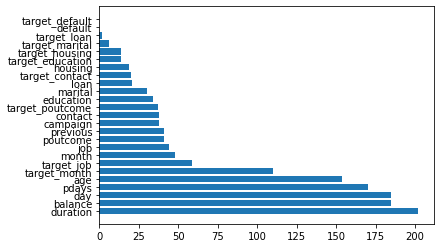

In [17]:
cols = list(X_train.columns)
f_importance = np.array(model.feature_importance())
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False)
plt.barh(df_importance['feature'], df_importance['importance'])
plt.show()

In [18]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print(y_pred)
# 反応率を出力

[0.76816576 0.07361535 0.01893207 ... 0.05854702 0.0024952  0.1136031 ]


# 提出ファイル作成

In [19]:
submit_df[1]=y_pred
submit_df.to_csv('beginner-'+datetime.date.today().isoformat()+".csv", index=False, header=False) #headerなしで出力
files.download('beginner-'+datetime.date.today().isoformat()+".csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>